In [1]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq

In [2]:

x = [95.,110,151,156,171,174,173,172,177,173,172,174,173,172,177,173,172,172,174,173,172,171,174,173,172,177,173,172,174,173,172,177,173,172,172,174,173,172]
st = length(x)
ode_data = transpose(hcat(x[1:st]))
u0 = [x[1]]
tspan = (0.0f0, 3.f0)
t = range(tspan[1], tspan[2], length = st)
species1 = "BPM"

"BPM"

In [3]:
ode_data

1×38 LinearAlgebra.Transpose{Float64,Array{Float64,2}}:
 95.0  110.0  151.0  156.0  171.0  …  172.0  172.0  174.0  173.0  172.0

In [4]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,l2s,times,count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

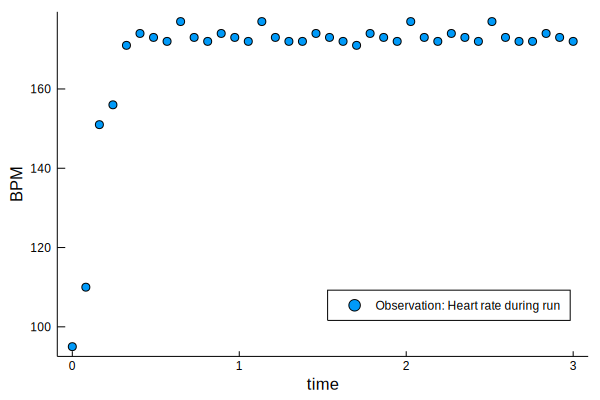

In [17]:
scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "BPM", label = "Observation: Heart rate during run", legend=:bottomright)

In [6]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(1,100,tanh),
       Dense(100,100,tanh),
        Dense(100,100,tanh),
       Dense(100,1))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Tsit5(), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 50000
verify = 500 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.0001)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()),Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0,Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end


#7 (generic function with 1 method)

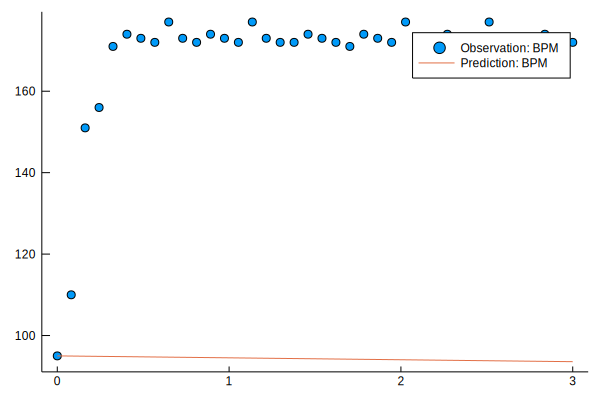

In [7]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))

In [8]:
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

858.272321 seconds (977.89 M allocations: 210.198 GiB, 7.22% gc time)


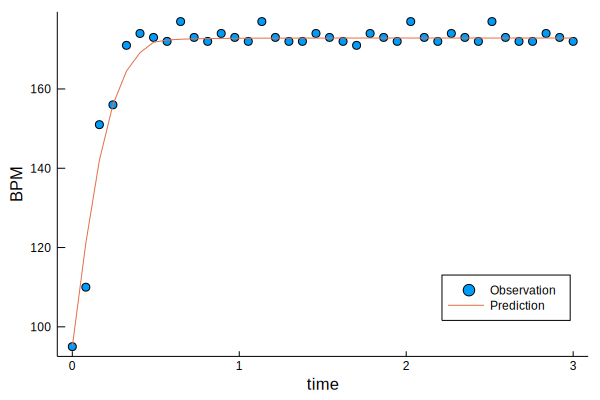

In [18]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation "), grid = "off", legend=:bottomright,xlab = "time", ylab = "BPM",)
plot!(t, Flux.data(pred[1,:]), label = string("Prediction "))

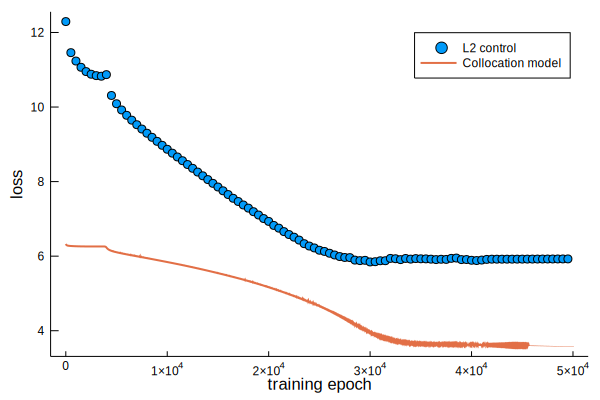

In [13]:
header = string("Collocation model")
scatter(range(1,stop=length(sa.l2s)),log.(sa.l2s),width  =2, label = "L2 control", grid = "off")
plot!(range(1,stop=length(sa.losses)),log.(sa.losses), width  =2, label = header, ylab ="loss", xlab = "training epoch")
# 5% of time even with l2s

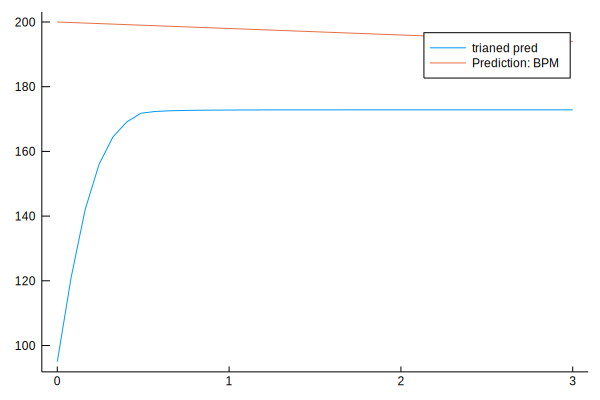

In [11]:
pred = n_ode(u0)
plot(t, Flux.data(pred[1,:]), label = string("trianed pred "), grid = "off")
pred = n_ode([200.])
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))